In [1]:
TEST_IMAGE_FILE = 't10k-images-idx3-ubyte'
TEST_LABEL_FILE = 't10k-labels-idx1-ubyte'
TRAIN_IMAGE_FILE = 'train-images-idx3-ubyte'
TRAIN_LABEL_FILE = 'train-labels-idx1-ubyte'


In [2]:
N_NEURONS = 400

In [3]:
import numpy as np
import brian2 as b
import struct
import os
import matplotlib.pyplot as plt
# from Memoizer import memoize_to_folder
from pprint import pprint

In [4]:
idx_data_type = {
    0x08: 'B',
    0x09: 'b',
    0x0B: 'h',
    0x0C: 'i',
    0x0D: 'f',
    0x0E: 'd'
}

def read_idx(filename, is_label=False):
    with open(filename, 'rb') as idx_file:
        idx_file.read(2) # Skip magic number
        
        data_type = idx_data_type[struct.unpack("B", idx_file.read(1))[0]]
        
        n_dims = struct.unpack("B", idx_file.read(1))[0]
        dims = struct.unpack(">" + "I"*n_dims, idx_file.read(4*n_dims))
        
        data = np.frombuffer(idx_file.read(), dtype=data_type)
        if is_label:
            return np.reshape(data, dims)
        else:
            return np.reshape(data, dims).astype(float) / 256
    
  
def normalize_imgs(imgs):
    sums = imgs.sum(1).sum(1)
    imgs = imgs / np.tile(sums, [28,28,1]).T
    imgs *= 100
    return imgs

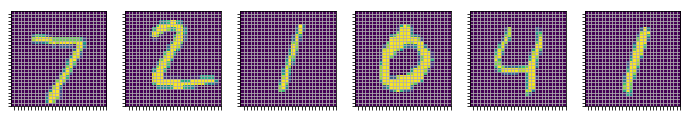

In [5]:
train_images = read_idx(TRAIN_IMAGE_FILE)
# train_images = normalize_imgs(train_images)
train_labels = read_idx(TRAIN_LABEL_FILE, True)

test_images = read_idx(TEST_IMAGE_FILE)
# test_images = normalize_imgs(test_images)
test_labels = read_idx(TEST_LABEL_FILE, True)

train_images.shape
plt.figure(figsize=(12,5))
plt_imgs = train_images[:10]
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(test_images[i], vmin = plt_imgs.min(), vmax=plt_imgs.max())
    plt.grid(which='major')
    plt.xticks(np.arange(28)+.5)
    plt.yticks(np.arange(28)+.5)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])



In [6]:
STIMULUS_SHAPE = test_images[0].shape

In [7]:
b.set_device('cpp_standalone')


In [8]:
b.prefs.codegen.cpp.extra_compile_args_gcc = ['-w', '-O3', '-ffast-math', '-fno-finite-math-only']

In [9]:
taum = 10*b.ms
taupre = 5*b.ms
taupost = taupre
Ee = 0*b.mV
vt = -54*b.mV
vr = -60*b.mV
El = -74*b.mV
taue = 5*b.ms
F = 15*b.Hz
gmax = .5
dApre = 1.
nu = 0.2
mu = 2
Atar = .15
wmax = .09
wmin = .01

In [10]:
eqs_neurons = '''
        dv/dt = ((vr - v) + (I_synE+I_synI) / nS) / (taum)  : volt
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-100.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''

In [11]:
N_INPUT = np.product(STIMULUS_SHAPE)
STIMULUS_TIME = 2 # seconds
N_STIMULI = 600
SILENCE_TIME = .25 # seconds
N_TEST_STIMULI = 200
FIXED_TIME = N_TEST_STIMULI * STIMULUS_TIME
# N_INPUT=100

# Resolves to 0 when t is within SILENCE_TIME of the end of a stimulus
# (Used to insert 0 Hz firing between each stimulus)
is_not_silence = \
    'int(t % (STIMULUS_TIME * second) < (STIMULUS_TIME - SILENCE_TIME) * second)'

def make_repeating_input_group(input_array, dt, on_rate = 50 * b.Hz):
    input_values = [x.flatten() * on_rate for x in input_array]
    stimulus = b.TimedArray(input_values, dt=dt)

    max_t = str(int(dt) * len(input_array)) + ' * second'
    print(max_t)
    PG = b.PoissonGroup(N_INPUT, rates = is_not_silence + ' * stimulus(t % ({}), i)'.format(max_t))
    return stimulus, PG

def make_changing_input_group(input_array, dt, on_rate = 50 * b.Hz):
    input_values = [x.flatten() * on_rate for x in input_array]
    stimulus = b.TimedArray(input_values, dt=dt)
    PG = b.PoissonGroup(N_INPUT, rates = 'stimulus(t, i)')
    return stimulus, PG

def make_static_input_group(input_matrix, on_rate = 90 * b.Hz):
    input_values = input_matrix.flatten() * on_rate
    print(input_values.shape)
#     print(input_values)
    PG = b.PoissonGroup(N_INPUT, rates = input_values)
    return PG

stimulus, input_group = make_repeating_input_group(train_images[:N_STIMULI], STIMULUS_TIME * b.second, 60.*b.Hz)
# stimulus, input_group = make_changing_input_group(test_images[:10], STIMULUS_TIME * b.second, 25.*b.Hz)
# input_group = make_static_input_group(test_images[0], 60 * b.Hz)
# # input_group = b.PoissonGroup(N, rates=15. * b.Hz)

1200 * second


In [12]:
N_NEURONS = 100

In [13]:
excitatory = b.NeuronGroup(N_NEURONS, eqs_neurons, 
                        threshold = 'v > vt', 
                        reset = 'v = vr')
excitatory.v = vr

IS_FIXED = 'int(t > {} * second)'.format(N_STIMULI * STIMULUS_TIME - FIXED_TIME)

S = b.Synapses(input_group, excitatory,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    ''',
             on_post='''
                    w = w * {IS_FIXED} + (1-{IS_FIXED}) * clip(w + nu*(Apre - Atar) * (wmax - w) ** mu, wmin, wmax)
                    '''.format(IS_FIXED=IS_FIXED),
             )
S.connect()
S.Apre = Atar

In [14]:
eqs_inhibitory = '''
        dv/dt = ((vr - v) + (I_synE) / nS) / (10*ms)  : volt
        I_synE = ge * nS *         -v                           : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        '''

In [15]:
inhibitory = b.NeuronGroup(N_NEURONS, eqs_inhibitory,
                           threshold = 'v >= vt',
                           reset = 'v = vr')
inhibitory.v = vr

e_to_i = b.Synapses(excitatory, inhibitory,
                    on_pre = '''
                        ge += 2.0
                    '''
                   )
e_to_i.connect(j='i')

i_to_e = b.Synapses(inhibitory, excitatory,
                    on_pre = '''
                        gi += .15
                    '''
                   )
i_to_e.connect('i != j')


WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [16]:
import time

run_duration = N_STIMULI * STIMULUS_TIME
S.w = 'wmax * 3.0/4.0 - rand() * (wmax/4.0)'
# orig_sw = np.array(S.w).copy()
w_mon = b.StateMonitor(S, 'w', dt = 1*b.second, record=range(N_NEURONS * N_INPUT))
e_mon = b.SpikeMonitor(excitatory, record=True)
i_mon = b.SpikeMonitor(inhibitory, record=True)
# ve_mon = b.StateMonitor(excitatory, 'v', record=range(5))
net = b.Network(input_group, S, excitatory, inhibitory, i_to_e, e_to_i, i_mon, e_mon, w_mon)
start_time = time.time()
net.run(run_duration * b.second, report='text')
end_time = time.time()

print("Ran in {} seconds".format(end_time - start_time))

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.03s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
WARNING    "i" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Ran in 386.083893061 seconds


In [17]:
i_mon.i

<spikemonitor_1.i: array([29, 78, 92, ..., 43, 60, 13], dtype=int32)>

In [18]:
def raster(mon, neurs = range(N_NEURONS), start=0, end=N_STIMULI * STIMULUS_TIME):
    ts = np.array(mon.t)
    print("Got ts")
    
    if start < 0:
        start = N_STIMULI * STIMULUS_TIME + start
    if end < 0:
        end = N_STIMULI * STIMULUS_TIME + end
    
    mask = (ts > start) & (ts < end)
    ts = ts[mask]
    mon_i = np.array(mon.i)
    mon_i = mon_i[mask]
    print("Plotting")
    for i in neurs:
        tsi = ts[mon_i == i]
        plt.plot(tsi, [i] * len(tsi), '.', markersize=.1)

<IPython.core.display.Javascript object>


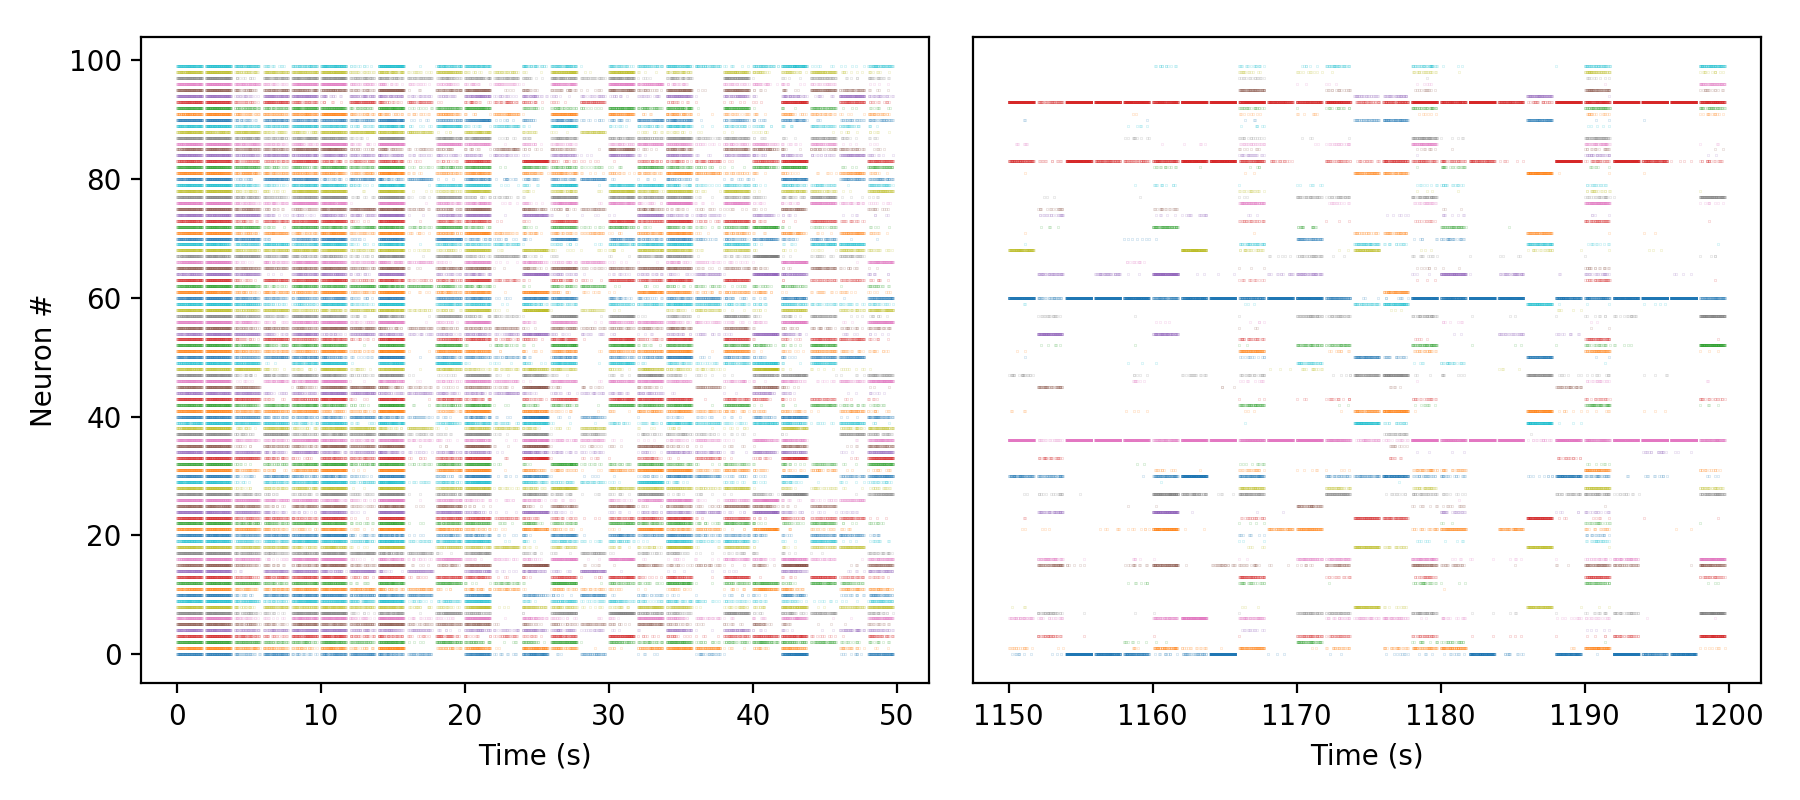

Got ts
Plotting
Got ts
Plotting


In [30]:
%matplotlib notebook
plt.figure(figsize=(9,4))
plt.subplot(121)
raster(i_mon, end=50)
plt.xlabel("Time (s)")
plt.ylabel("Neuron #")
plt.subplot(122)
raster(i_mon, start=-50)
plt.yticks([])
plt.xlabel("Time (s)")
plt.tight_layout()
plt.savefig("Raster.png")

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt

def show_weights(w, delta_only = False):
    if not delta_only:
        mn = wmin #min(w)# - orig_w.flatten())
        mx = wmax # max(w)# - orig_w.flatten())
    else:
        mn = min(w - orig_w.flatten())
        mx = max(w - orig_w.flatten())
    w = np.array(w).reshape((28,28,N_NEURONS))

    
    for i in range(N_NEURONS):
        plt.subplot(np.floor(np.sqrt(N_NEURONS)),np.ceil(np.sqrt(N_NEURONS)),i+1)
        plt.imshow(w[:,:,i] - (orig_w[:,:,i] if delta_only else 0), vmin=mn, vmax=mx)  
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])
        
    plt.subplot(10, 10, 5)
    plt.title(" ")
    plt.tight_layout(w_pad=0, h_pad=0)
    plt.title("       Neuron Connection Weights")

In [21]:
weights = w_mon.w.reshape([STIMULUS_SHAPE[0],STIMULUS_SHAPE[1],N_NEURONS, -1])

<IPython.core.display.Javascript object>


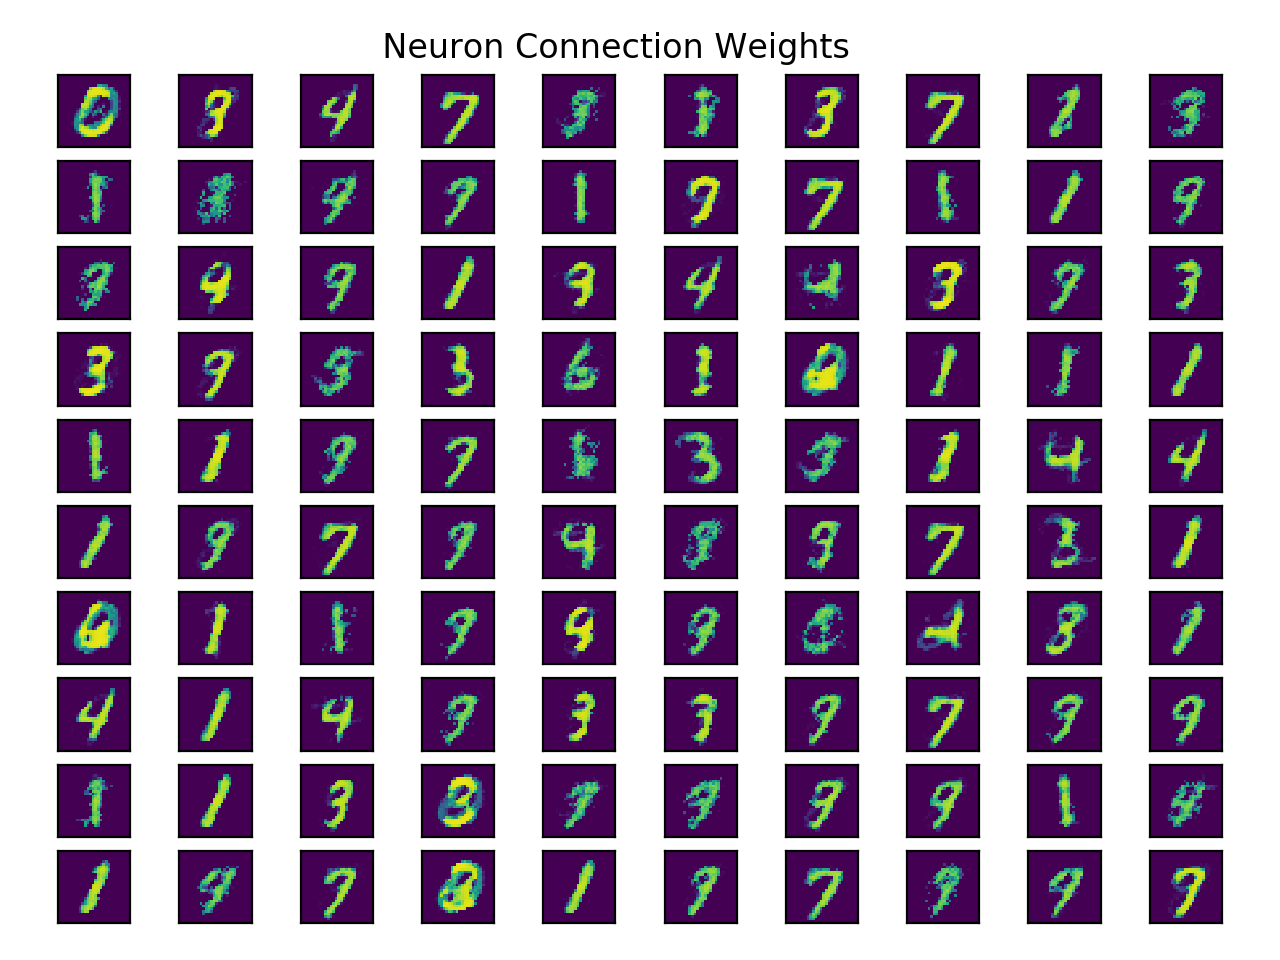

In [29]:
%matplotlib notebook
plt.figure()
show_weights(weights[:,:,:,-1], False)
plt.savefig("Weights.png")

<IPython.core.display.Javascript object>


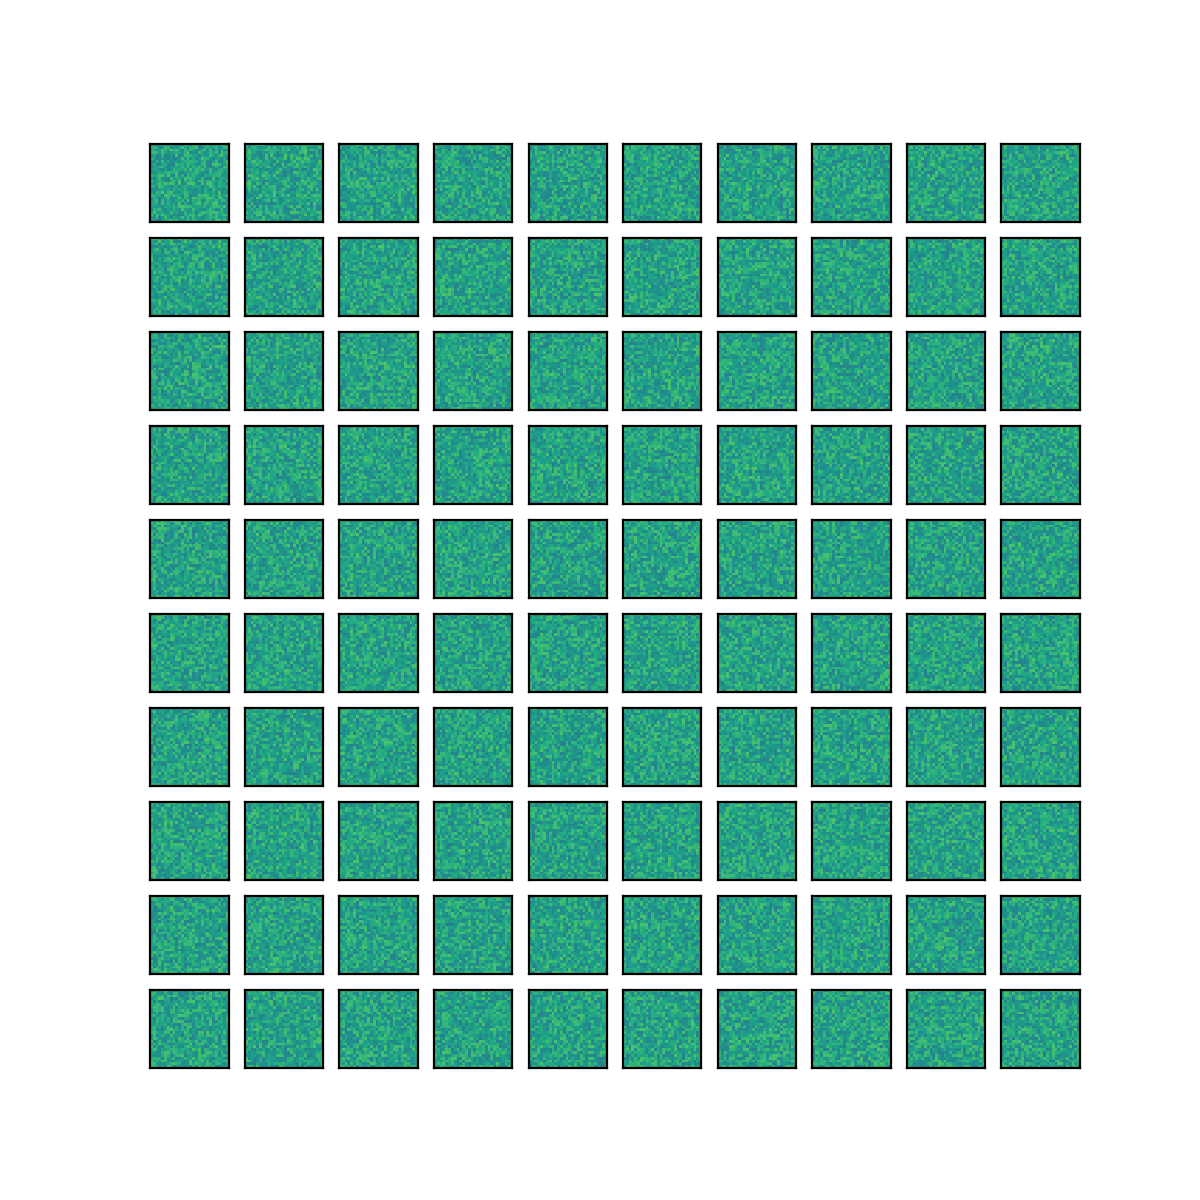

In [23]:
%matplotlib notebook
from matplotlib import animation, rc
from IPython.display import HTML
# def create_weight_animation(w_mon):

N_FRAMES = 500

weights = w_mon.w.reshape([STIMULUS_SHAPE[0],STIMULUS_SHAPE[1],N_NEURONS, -1])

fig = plt.figure(figsize=(6,6))

plots = []

for i in range(N_NEURONS):
    plt.subplot(np.floor(np.sqrt(N_NEURONS)),np.ceil(np.sqrt(N_NEURONS)),i+1)
    plots.append(plt.imshow(weights[:,:,i,0], vmin=wmin, vmax=wmax))
    plt.xticks([])
    plt.yticks([])

ts = []    
    
def animate(t):
    ts.append(t)
    for i in range(N_NEURONS):
        plots[i].set_data(weights[:,:,i,min(t, weights.shape[-1]-1)])

anim = animation.FuncAnimation(fig, animate,
                               frames = range(0,weights.shape[-1]+1,max((weights.shape[-1]/N_FRAMES,1))),
                               interval=.1,
                               blit=True)


In [24]:
anim.save('weights_normalized.mp4', fps=25)

In [25]:
weights.shape

(28, 28, 100, 1200)

In [26]:
train_labels[200:250]

array([1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6,
       4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7,
       5, 8, 0, 9, 1, 0], dtype=uint8)

In [27]:
import pprint
import pandas as pd
import collections
def get_firing_rates(monitor, labels, n_to_use):
    m_ts = np.array(monitor.t)
    m_i = np.array(monitor.i)
    
    start_stimuli = N_STIMULI - n_to_use

    datas = []
    for i, label in enumerate(labels):
        if i < start_stimuli:
            continue
        tlim = (STIMULUS_TIME * i, STIMULUS_TIME * i+1)
        
        mask = (m_ts > tlim[0]) & (m_ts < tlim[1])
        fire_times = m_ts[mask]
        fire_labels = m_i[mask]
        
        data = {'i': i, 'label': label}
        for j in range(100):
            data[j] = 0
        
        data.update(collections.Counter(fire_labels))
        
        datas.append(data)
        
    return pd.DataFrame(datas)
            
    
frs = get_firing_rates(i_mon, train_labels[:N_STIMULI], N_TEST_STIMULI)


<IPython.core.display.Javascript object>


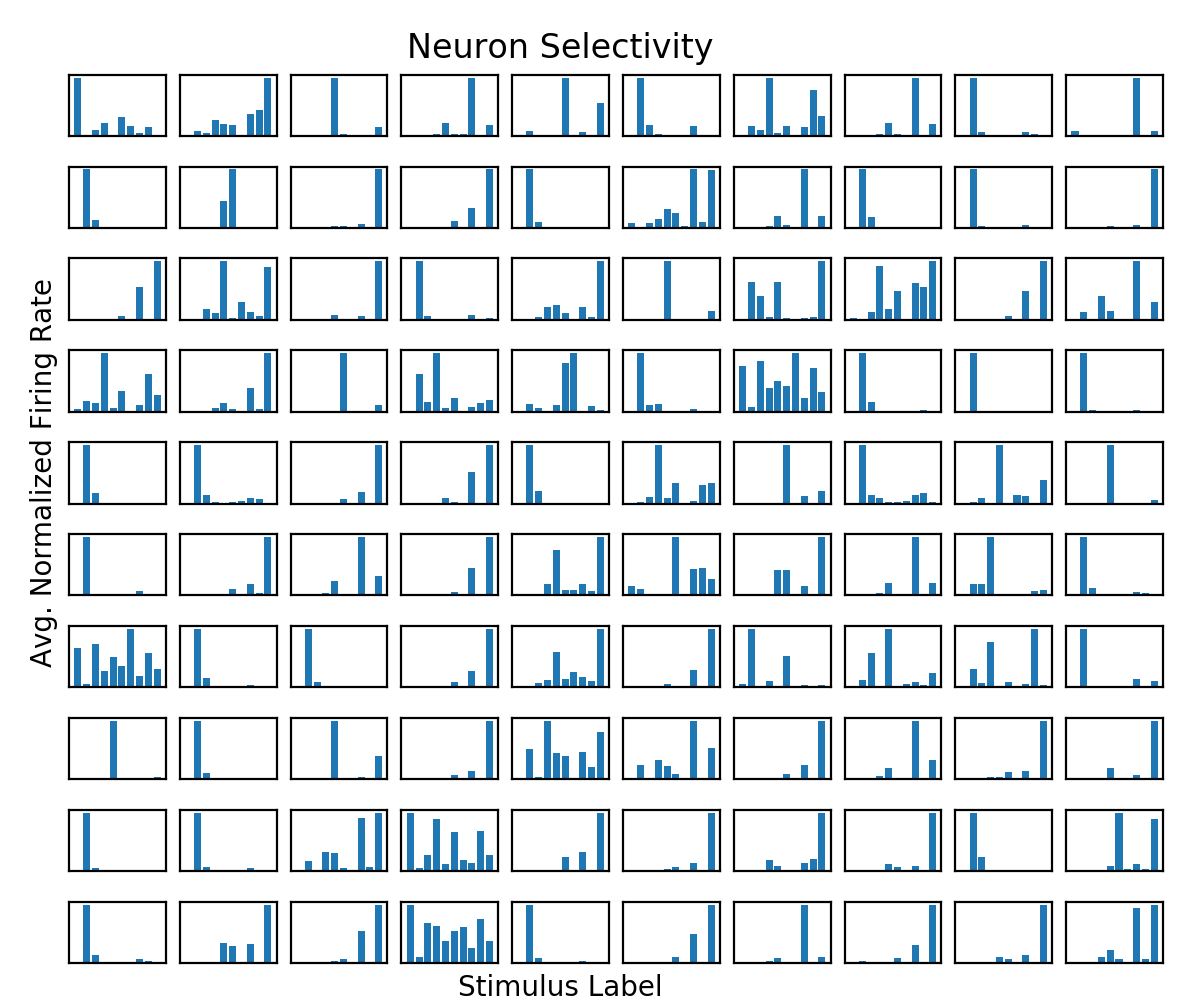

WARNING    /home/iped/.local/lib/python2.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
 [py.warnings]


In [28]:
norm_frs = frs.copy()
norm_frs.iloc[:,:-2] /= frs.iloc[:,:-2].max(axis=0)

means = norm_frs.groupby('label').mean()
plt.figure(figsize=(6,5))
for i in range(N_NEURONS):
    plt.subplot(np.sqrt(N_NEURONS), np.sqrt(N_NEURONS), i+1)
    plt.bar(np.arange(10), means[i].values)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-1, 10])
    
plt.subplot(10, 10, 41)
plt.ylabel("Avg. Normalized Firing Rate")
plt.subplot(10, 10, 5)
plt.title(" ")

plt.tight_layout(w_pad=0, h_pad=0)

plt.subplot(10, 10, 95)
plt.xlabel("Stimulus Label")

plt.subplot(10, 10, 5)
plt.title("Neuron Selectivity")

plt.savefig("Selectivity.png")